In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import socket
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
import requests
from IPython.display import display
import matplotlib.pyplot as plt

In [3]:
# ✅ Define Local Paths
dataset_path = "./DATASET"
train_dir = os.path.join(dataset_path, "TRAIN")
test_dir = os.path.join(dataset_path, "TEST")
save_model_path = "./saved_models/waste_classifier.h5"

In [4]:
# ✅ Image Preprocessing & Augmentation
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 22749 images belonging to 2 classes.
Found 2648 images belonging to 2 classes.


In [5]:
# ✅ Load MobileNetV2 Base Model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
# ✅ Train the Model
model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,
    steps_per_epoch=len(train_data),
    validation_steps=len(test_data)
)

c:\Users\adith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 714s 993ms/step - accuracy: 0.8936 - loss: 0.2637 - val_accuracy: 0.8361 - val_loss: 0.3639
Epoch 2/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 713s 1s/step - accuracy: 0.9344 - loss: 0.1746 - val_accuracy: 0.8199 - val_loss: 0.3870
Epoch 3/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 674s 947ms/step - accuracy: 0.9400 - loss: 0.1549 - val_accuracy: 0.8508 - val_loss: 0.3429
Epoch 4/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 614s 864ms/step - accuracy: 0.9452 - loss: 0.1407 - val_accuracy: 0.8659 - val_loss: 0.3095
Epoch 5/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 727s 1s/step - accuracy: 0.9483 - loss: 0.1367 - val_accuracy: 0.8082 - val_loss: 0.3965
Epoch 6/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 724s 1s/step - accuracy: 0.9502 - loss: 0.1331 - val_accuracy: 0.8501 - val_loss: 0.3415
Epoch 7/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 708s 996ms/step - accuracy: 0.9518 - loss: 0.1218 - val_accuracy: 0.8282 - val_loss: 0.3707
Epoch 8/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 704s 990ms/step - accuracy: 0.9521 - loss: 0.

In [ ]:
# ✅ Save Model Locally
os.makedirs("./saved_models", exist_ok=True)
model.save(save_model_path)
print(f"Model saved at {save_model_path}")

In [8]:
try:
    esp_ip = socket.gethostbyname("esp32.local")
    print(f"ESP32 IP Address: {esp_ip}")
except socket.gaierror as e:
    print(f"Error resolving ESP32 hostname: {e}")
    esp_ip = None  # Set to None if resolution fails

ESP32 IP Address: 192.168.1.23


In [9]:
# ✅ ESP Communication Setup


def send_request(waste_type):
    if esp_ip is None:
        print("❌ Cannot send request: ESP32 IP is unknown!")
        return
    
    url = f"http://{esp_ip}/{waste_type}"
    try:
        response = requests.get(url, timeout=3)
        print("ESP Response:", response.text)
    except requests.RequestException as e:
        print(f"Error: {e}")

#send_request("bio")

In [10]:
# ✅ Real-Time Detection Using Webcam
def classify_waste_webcam():
    cap = cv2.VideoCapture(0)
    print(f"Using ESP at {"esp32.local"}")
    
    if not cap.isOpened():
        print("⚠️ Error: Could not access webcam!")
        return
    
    print("📷 Press SPACE to capture an image & classify, ESC to exit")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ Failed to grab frame")
            break
        
        cv2.imshow("Webcam", frame)
        key = cv2.waitKey(1) & 0xFF
        
        if key == 32:  # SPACE key to capture
            img_path = "captured_waste.jpg"
            cv2.imwrite(img_path, frame)
            classify_waste(img_path)
        elif key == 27:  # ESC key to exit
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [11]:
# ✅ Function to Classify a Given Image & Send Result to ESP
def classify_waste(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0) / 255.0
    
    prediction = model.predict(img)[0][0]
    waste_type = "bio" if prediction < 0.4 else "non-bio"
    print(f"🗑️ Detected Waste Type: {waste_type}")
    
    send_request(waste_type)  # Send classification result to ESP
    
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title("Biodegradable 🟢" if waste_type == "bio" else "Non-Biodegradable 🔴")
    plt.axis("off")
    plt.show()

Using ESP at esp32.local
📷 Press SPACE to capture an image & classify, ESC to exit
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🗑️ Detected Waste Type: non-bio
ESP Response: Non-Biodegradable Waste Command Received



c:\Users\adith\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


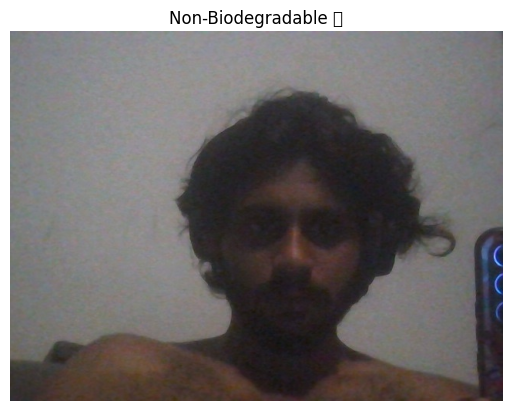

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
🗑️ Detected Waste Type: non-bio
ESP Response: Non-Biodegradable Waste Command Received



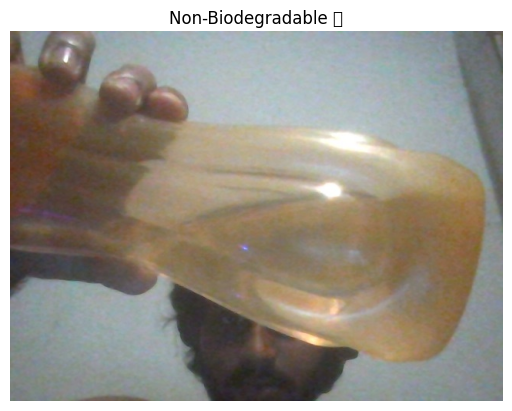

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
🗑️ Detected Waste Type: bio
ESP Response: Biodegradable Waste Command Received



c:\Users\adith\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


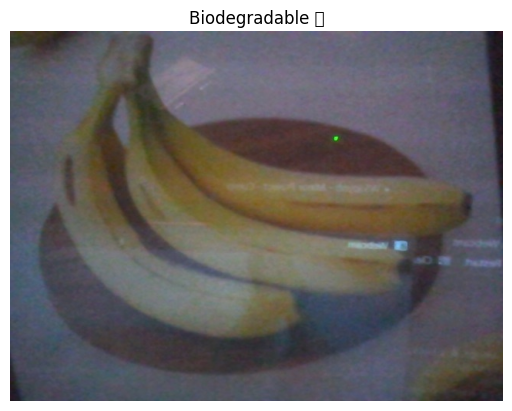

KeyboardInterrupt: 

In [12]:
# ✅ Run Classification from Webcam
classify_waste_webcam()
